## Colab Setting

In [48]:
# Rendering problems in Colab 
# https://stackoverflow.com/questions/63250935/nameerror-name-base-is-not-defined-while-running-open-ai-gym-in-google-colab
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

!pip3 install box2d-py
!pip3 install gym[Box_2D]

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()
#=========================================================#

import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

# why unwrapped
# https://stackoverflow.com/questions/53836136/why-unwrap-an-openai-gym
env = gym.make('CartPole-v0').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.10).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## DQN

### Module

It's said that using nn.Sequential will trigger some unknown issues.

In [49]:
# class DQN(nn.Module):
#   def __init__(self, state_dim, action_dim):
#     super(DQN, self).__init__()
#     self.fc1 = nn.Linear(state_dim, 64)
#     self.fc2 = nn.Linear(64, 64)
#     self.fc3 = nn.Linear(64, action_dim)

#   def forward(self, x):
#     x = F.relu(self.fc1(x))
#     x = F.relu(self.fc2(x))
#     return self.fc3(x)

And, it seems like it won't  : )
Anyway, I will keep both implementations.

In [50]:
class DQN(nn.Module):
  def __init__(self, state_dim, action_dim):
    super(DQN, self).__init__()
    self.net = nn.Sequential(
        nn.Linear(state_dim, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, action_dim),
    )
  
  # Better way is to use module.net(x)
  # since when using nn.Sequential, 
  # module(x) sometime output variants different from the network output
  def forward(self, x):
    return self.net(x)

### Replay Buffer

In [51]:
# Use namedtuple and deque data structures as transition for simplicity
# In fact, using list and numpy.array can also achieve it easily
Transition = namedtuple('Transition',
             ('state', 'action', 'next_state', 'reward', 'done'))  #(s, a, s', r)

class ReplayBuffer(object):
  def __init__(self, capacity):
    self.memory = deque(maxlen=capacity)

  def push(self, *args):
    self.memory.append(Transition(*args))

  def sample(self, batch_size):
    transitions = random.sample(self.memory, batch_size)
    # *data_structure means unpacking the elements inside it
    # zip means aggregating elements at same index from different lists
    # see below
    batch = Transition(*zip(*transitions))

    states = torch.cat(batch.state)
    actions = torch.cat(batch.action)
    next_states = torch.cat(batch.next_state)
    rewards = torch.cat(batch.reward)
    dones = torch.cat(batch.done)

    return states, actions, next_states, rewards, dones

  def __len__(self):
    return len(self.memory)

In [52]:
a = ReplayBuffer(5)
a.push(0,1,2,3,4)
a.push('a','b','c','d','e')
b = random.sample(a.memory, 2)
c = Transition(*zip(*b))
list(zip(*b))

[(0, 'a'), (1, 'b'), (2, 'c'), (3, 'd'), (4, 'e')]

### Agent

In [53]:
# hyper-parameters
# another way to store self.xxx = xxx in self.init
BUFFER_SIZE = 100000   #1e5
BATCH_SIZE = 64
GAMMA = 0.99
TAU = 1e-3        # soft update param of target net
LR = 5e-4
UPDATE_EVERY = 4

In [65]:
class DQNAgent():
  def __init__(self, state_dim, action_dim):
    self.state_dim = state_dim
    self.action_dim = action_dim

    self.policy_net = DQN(state_dim, action_dim).to(device)
    self.target_net = DQN(state_dim, action_dim).to(device)

    self.optimizer = optim.Adam(self.policy_net.parameters(), lr=LR)

    self.replay_buffer = ReplayBuffer(BUFFER_SIZE)
    self.time_step = 0

  def select_action(self, state, epsilon=0.):
    state = torch.from_numpy(state).float().unsqueeze(0).to(device)
    
    # epsilon-greedy
    if random.random() > epsilon:
      with torch.no_grad():
        action_values = self.policy_net(state)
        action = np.argmax(action_values.cpu().data.numpy())

    else:
      action = random.choice(np.arange(self.action_dim))
    return action

  def soft_update(self, policy_net, target_net, tau):
    for policy_param, target_param in zip(policy_net.parameters(), target_net.parameters()):
      target_param.data.copy_(tau*policy_param.data + (1.0-tau)*target_param.data)
  
  def update(self, gamma=GAMMA):
    states, actions, next_states, rewards, dones = self.replay_buffer.sample(BATCH_SIZE)

    # torch.gather is used to select predicted q value according to the action
    # here, the action is actually just number, and can be considered as index
    # see below
    q_predicted = self.policy_net(states).gather(dim=1, index=actions.unsqueeze(1))
    q_predicted = q_predicted.to(torch.float64)

    q_targets_next = self.target_net(next_states).detach().max(1)[0].unsqueeze(1)
    q_targets = rewards.unsqueeze(1) + gamma * q_targets_next * (1 - dones.unsqueeze(1))

    loss = F.mse_loss(q_predicted, q_targets)

    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    self.soft_update(self.policy_net, self.target_net, TAU)

  def step(self, state, action, next_state, reward, done):
    state = torch.tensor([state], device=device)
    action = torch.tensor([action], device=device)
    next_state = torch.tensor([next_state], device=device)
    reward = torch.tensor([reward], device=device)

    if done:
      done = torch.tensor([1.0], device=device)
    else:
      done = torch.tensor([0.0], device=device)

    self.replay_buffer.push(state, action, next_state, reward, done)
    self.time_step = (self.time_step + 1) % UPDATE_EVERY
    if self.time_step == 0:
      if len(self.replay_buffer) > BATCH_SIZE:
        self.update()

In [ ]:
# QVs = torch.tensor([[-3.4730, -0.3599, -0.4901, -4.2896],
#            [-1.5212, -0.2213, -0.6813, -2.0883],
#            [-4.0442, -0.2986, -0.2717, -4.4006],
#            [-1.8476, -1.6259, -1.6947, -2.0288],
#            [-1.3694, -1.4016, -1.6368, -1.6871]], grad_fn=<SliceBackward0>)
# AC = torch.tensor([[0],
#           [2],
#           [2],
#           [0],
#           [0]])
# Q = torch.tensor([[-3.4730],
#           [-0.6813],
#           [-0.2717],
#           [-1.8476],
#           [-1.3694]], grad_fn=<SliceBackward0>)

## Training

In [55]:
from datetime import datetime

def train(agent, num_episodes=2000, max_timestep=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
  scores = []
  scores_window = deque(maxlen=100)
  eps = eps_start
  start_time = datetime.now().replace(microsecond=0)

  for i_episode in range(1, num_episodes+1):
    state = env.reset()
    score = 0
    for t in range(max_timestep):
      action = agent.select_action(state, eps)
      next_state, reward, done, _ = env.step(action)
      agent.step(state, action, next_state, reward, done)

      state = next_state
      score += reward
      
      if done:
        break

    scores_window.append(score)
    scores.append(score)
    eps = max(eps_end, eps_decay*eps)

    print('\rEpisode {}\tScore: {:.2f}\tAverage Score: {:.2f}'.format(i_episode, score, np.mean(scores_window)), end='')
    if i_episode % 100 == 0:
      print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
    if np.mean(scores_window) >= 200.0:
      print('\nEnvironment solved in {:d} episodes!\tAverage Score {:.2f}'.format(i_episode-100, np.mean(scores_window)))
      break
  
  end_time = datetime.now().replace(microsecond=0)
  print("Total training time  : ", end_time - start_time)

  return scores

Episode 100	Average Score: -139.03
Episode 200	Average Score: -83.75
Episode 300	Average Score: -63.62
Episode 400	Average Score: -35.66
Episode 500	Average Score: -4.87
Episode 600	Average Score: 43.98
Episode 700	Average Score: 150.36
Episode 755	Score: 265.38	Average Score: 200.52
Environment solved in 655 episodes!	Average Score 200.52
Total training time  :  0:17:10


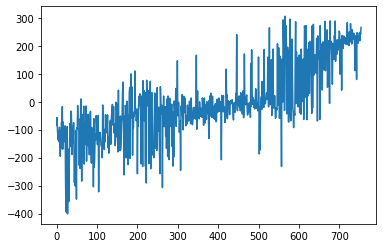

In [57]:
env = gym.make('LunarLander-v2')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

agent = DQNAgent(state_dim, action_dim)
dqn_scores = train(agent)
plt.plot(dqn_scores)

## Double DQN

Double DQN in fact still follow the same procedure of learning and update, except it use different networks for predicting next action and evaluating the action_next (predicting next q value).

In DQN, q_value_next is calculated by the max operation of the next prossible q values. This max actually is the simplification of using the same network (in our case target_network) to first predict the action_next, then select the q_value according to it. This MAX operation will introduce overestimation analysed in Double DQN paper.

To alleviate it, we can use different networks to do the action evaluation and selection, and that's the key idea of Double DQN.

In [58]:
class DoubleDQNAgent(DQNAgent):
  def predict_action(self, states):
    _, actions = self.policy_net(states).max(dim=1, keepdim=True)
    return actions

  def update(self, gamma=GAMMA):
    states, actions, next_states, rewards, dones = self.replay_buffer.sample(BATCH_SIZE)
    
    q_predicted = self.policy_net(states).gather(1, index=actions.unsqueeze(1))
    q_predicted = q_predicted.to(torch.float64)

    actions_next = self.predict_action(next_states)  # Use policy_net for actions selection
    q_values_next = self.target_net(next_states).gather(dim=1, index=actions_next)  # and use target_net to evaluate the selection
    q_targets = rewards.unsqueeze(1) + gamma * q_values_next * (1 - dones.unsqueeze(1))

    loss = F.mse_loss(q_predicted, q_targets)

    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    self.soft_update(self.policy_net, self.target_net, TAU)

In [59]:
env = gym.make('LunarLander-v2')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

agent1 = DoubleDQNAgent(state_dim, action_dim)
double_dqn_scores = train(agent1)

Episode 100	Average Score: -186.33
Episode 200	Average Score: -137.02
Episode 300	Average Score: -52.91
Episode 400	Average Score: 29.54
Episode 500	Average Score: 152.54
Episode 600	Average Score: 161.66
Episode 700	Average Score: 191.41
Episode 716	Score: 251.28	Average Score: 201.31
Environment solved in 616 episodes!	Average Score 201.31
Total training time  :  0:13:31


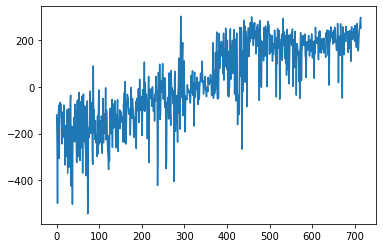

In [60]:
plt.plot(double_dqn_scores)

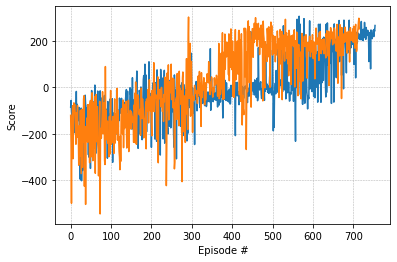

In [62]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(dqn_scores)), dqn_scores)
plt.plot(np.arange(len(double_dqn_scores)), double_dqn_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

## Conclusion

From the plotting above, it's clear that Double DQN can both achieve high score (above 200) earlier and solved the environment (achieve 200 on average for 100 episodes) faster than DQN.

But the big problems hinder DQN for application is that, for one thing, it can only work for discrete action space. This is because the action is selected by epsilon greedy policy (max operation).

For another, it can not extend to high dimension. From the my own experience in the experiment, I found that if the agent somehow failed to visit the goal state (so that achieving high score in a certain frequency), it may not converaged at all. In other words, the convergence of DQN heavily depends on the possibility of the agent can visit the goal state. In higher dimension state space and action space, the possibility is comparatively low, making the algorithm hardly to work.

Another way to think this problem is that, for DQN, the max operation making the agent hard to back propagate the gradients, to reason about a policy to perform better from the data it encounters. That's also why the upcoming algorthms are PG-based. And it's said that even the author of DQN paper, Volodymyr Mnih, agreed that PG can perform better than DQN if it's tuned well.

However, the papar and the implementation of DQN are still remarkable. It is their works which make DRL become a hot topic and therefore the following trend of research. Also, two tricks in the implementation of DQN, replay buffer and target network, solving the problems which hinder combining deep machine learning with reinforcement learning (transitions are not i.i.d) and using function approximator (target is varying therefore hard to converge). These two ideas are continuous appeared in the following algorithms.